In [64]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes
## for statistical tests
import scipy
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
# from lime import lime_tabular
import matplotlib.ticker as plticker
import pickle

In [65]:
#Predit on the test set
dfs = pd.read_csv("train.csv")
dfs.head()

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category
0,3222,1,1,1,14,1,1,1,13,28,...,0,6,7,6,14.714286,0,11.1,0.6,2.02,Graduate
1,2388,1,8,4,9,1,1,1,23,14,...,0,5,10,2,12.500000,0,11.1,0.6,2.02,Dropout
2,1865,1,12,1,17,0,1,1,1,1,...,0,5,5,5,12.400000,0,15.5,2.8,-4.06,Graduate
3,652,1,12,1,12,1,12,1,1,5,...,0,8,11,7,12.614286,0,12.7,3.7,-1.70,Graduate
4,4220,1,1,1,14,1,1,1,19,28,...,0,5,5,0,0.000000,0,9.4,-0.8,-3.12,Dropout


In [66]:
#ENCODING
dfs = pd.get_dummies(dfs, columns=['Marital status'])
dfs = pd.get_dummies(dfs, columns=['Application mode'])
dfs = pd.get_dummies(dfs, columns=['Course'])
dfs = pd.get_dummies(dfs, columns=['Previous qualification'])
dfs = pd.get_dummies(dfs, columns=['Nacionality'])
dfs = pd.get_dummies(dfs, columns=["Mother's occupation"])
dfs = pd.get_dummies(dfs, columns=["Father's occupation"])

#DROP AND CREATE
dfs = dfs.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfs["valid_enroll_sem2"] = dfs["Curricular units 2nd sem (enrolled)"] - dfs["Curricular units 2nd sem (approved)"]

#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfs.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfs.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfs["Category"]
dtf_scaled["Id"] = dfs["Id"]
dfs = dtf_scaled

#features selection
df = dfs[["Id", "Curricular units 2nd sem (approved)", "valid_enroll_sem2",
"Curricular units 2nd sem (grade)",
"Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
"Unemployment rate",
"GDP",
"Inflation rate",
"Curricular units 2nd sem (enrolled)",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10",
"Displaced", "Category"]]

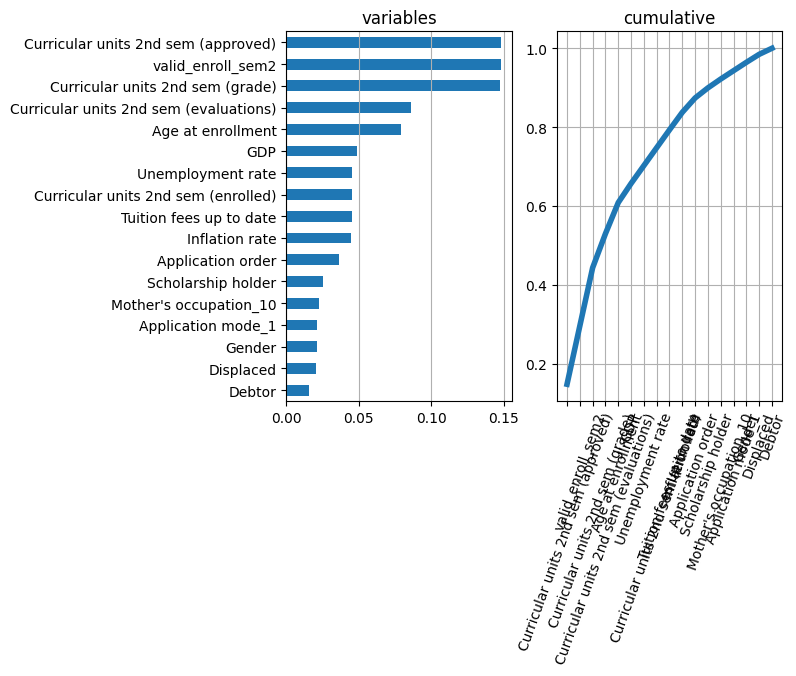

,IMPORTANCE,cumsum
VARIABLE,,
Curricular units 2nd sem (approved),0.147982,0.147982
valid_enroll_sem2,0.147880,0.295862
Curricular units 2nd sem (grade),0.147544,0.443406
Curricular units 2nd sem (evaluations),0.086320,0.529726
Age at enrollment,0.078875,0.608601
GDP,0.048495,0.657097
Unemployment rate,0.045383,0.702479
Curricular units 2nd sem (enrolled),0.045344,0.747823
Tuition fees up to date,0.045304,0.793127


In [67]:
# Plot
X = df.drop(["Category", "Id"], axis=1).values
y = df["Category"].values
feature_names = df.drop(["Category", "Id"], axis=1).columns

model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas df
dfs_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False).nlargest(20,"IMPORTANCE")
dfs_importances['cumsum'] = dfs_importances['IMPORTANCE'].cumsum(axis=0)
dfs_importances = dfs_importances.set_index("VARIABLE")
    
## Plot

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].title.set_text('variables')
dfs_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dfs_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dfs_importances)), xticklabels=dfs_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()
dfs_importances.head(20)

In [68]:
X_names = ["valid_enroll_sem2",
"Curricular units 2nd sem (grade)",
# "Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
# "Unemployment rate",
# "GDP",
"Inflation rate",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10",
"Displaced"]

X_train = dfs[X_names].values
y_train = dfs["Category"].values

## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=10, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 1, 'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 2, 'learning_rate': 0.01}
Best Model mean accuracy: 0.7536469534050179


In [47]:
## train
model.fit(X_train, y_train)
# save the model to disk
filename = 'finalized_model_academic_V3.sav'
pickle.dump(model, open(filename, 'wb'))

In [48]:
# validation

dfv = pd.read_csv("validation.csv")
#ENCODING
dfv = pd.get_dummies(dfv, columns=['Marital status'])
dfv = pd.get_dummies(dfv, columns=['Application mode'])
dfv = pd.get_dummies(dfv, columns=['Course'])
dfv = pd.get_dummies(dfv, columns=['Previous qualification'])
dfv = pd.get_dummies(dfv, columns=['Nacionality'])
dfv = pd.get_dummies(dfv, columns=["Mother's occupation"])
dfv = pd.get_dummies(dfv, columns=["Father's occupation"])

#DROP AND CREATE
dfv = dfv.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfv["valid_enroll_sem2"] = dfv["Curricular units 2nd sem (enrolled)"] - dfv["Curricular units 2nd sem (approved)"]

#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfv.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfv.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfv["Category"]
dtf_scaled["Id"] = dfv["Id"]
dfv = dtf_scaled

#features selection
dfv = dfv[["Id", "Curricular units 2nd sem (approved)", "valid_enroll_sem2",
"Curricular units 2nd sem (grade)",
"Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
"Unemployment rate",
"GDP",
"Inflation rate",
"Curricular units 2nd sem (enrolled)",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10",
"Displaced", "Category"]]

#Validation score see

X_validation = dfv[["valid_enroll_sem2",
"Curricular units 2nd sem (grade)",
"Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
"Unemployment rate",
"GDP",
"Inflation rate",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10",
"Displaced"]].values
y_validation = dfv["Category"].values

loaded_model = pickle.load(open("finalized_model_academic_V3.sav", 'rb'))
result = loaded_model.score(X_validation, y_validation)
print(result)


0.7469879518072289
